# Latent Dichrichlet Allocation

In [8]:
import sys
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'seek', 'can', 'the', 'a', 'this', 'its', 'as', 'such', 'fund', 'investment', 'invest', 'asset', 'portfolio', 'equity', 'aim'])

# Spacy for lemmatize
import spacy
nlp = spacy.load('en')

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
#tqdm_notebook.pandas('Progress')

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as sns

## Load Data

In [2]:
dir_out = input("Enter your directory for LDA outputs: ")

Enter your directory for LDA outputs:  ./outputs/lda/


In [3]:
kiid2table = pd.read_excel("./outputs/kiid8000/kiidoc2table.xlsx")
kiid2table.head()

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self,

Unnamed: 0                                          name_file  \
0           0  KIIDOC-2019-12-20-EN-CH-2020-01-06-157241-0900...   
1           0  KIIDOC-2020-02-19-EN-GB-2020-02-17-283156-0900...   
2           0  KIIDOC-2019-05-22-EN-00-2019-05-21-339044-0900...   
3           0  KIIDOC-2019-06-17-EN-00-2019-06-17-330896-0900...   
4           0  KIIDOC-2020-02-28-EN-GB-2020-02-28-358013-0900...   

    share_class                        subfund         umbrella_fund  \
0  LU0823429740                   India Equity     BNP Paribas Funds   
1  LU1664645287                           Aqua     BNP Paribas Funds   
2  LU1981115113  Invesco US Value Equity Fund        Invesco Funds     
3  LU1934329050     Invesco ASEAN Equity Fund         Invesco Funds    
4  LU2066071577                     SMaRT Food     BNP Paribas Funds   

                                          objectives  \
0    The Fund seeks to increase the value of its ...   
1    The Fund seeks to increase the value of its ...   
2    The objective of the Fund is to achieve long...   
3    The objective of the Fund is to achieve long...   
4    The Fund seeks to increase the value of its ...   

                                               risks  \
0    Lower risk Higher risk Other risks materiall...   
1    Lower risk Higher risk Other risks materiall...   
2    Other RisksLower Risk Higher Risk n The valu...   
3    Other RisksLower Risk Higher Risk n The valu...   
4    Lower risk Higher risk Other risks materiall...   

                                         description  \
0  Key Investor InformationThis document provides...   
1  Key Investor InformationThis document provides...   
2  Key Investor Information This document provide...   
3  Key Investor Information This document provide...   
4  Key Investor InformationThis document provides...   

                                                   0  
0   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
1   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
2   Invesco Management S.A., part of the Invesco ...  
3   Invesco Management S.A., part of the Invesco ...  
4   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...

In [4]:
kiid2terms = pd.read_excel("./outputs/kiid8000/kiidoc2terms.xlsx")
kiid2terms.head()

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self,

Unnamed: 0    # type                                 key  pattern  \
0         0.0  1.0    T                 nn: investment team      N N   
1         1.0  2.0    T              nnn: bank business day    N N N   
2         2.0  3.0    T   annn: bnp pariba asset management  A N N N   
3         3.0  4.0    T             npn: investment of fund    N P N   
4         4.0  5.0    T  ann: sustainable investment policy    A N N   

  Unnamed: 5                          pilot  spec    freq   dFreq  ...  \
0          1                investment team  5,10  2531.0  2447.0  ...   
1          0             bank business days  5,09  2471.0  2460.0  ...   
2          0   BNP PARIBAS ASSET MANAGEMENT  5,08  2456.0  2456.0  ...   
3        NaN        investments of the Fund  5,08  2447.0  2447.0  ...   
4        NaN  Sustainable Investment Policy  5,07  2375.0  2375.0  ...   

  Relation is_a restrictions  has  is_part of attribute Unnamed: 20  \
0      NaN               NaN  NaN         NaN       NaN         NaN   
1      NaN               NaN  NaN         NaN       NaN         NaN   
2      NaN               NaN  NaN         NaN       NaN         NaN   
3      NaN               NaN  NaN         NaN       NaN         NaN   
4      NaN               NaN  NaN         NaN       NaN         NaN   

          synonyme entity entity2  \
0              NaN    NaN     NaN   
1              NaN    NaN     NaN   
2              NaN    NaN     NaN   
3  fund_investment    NaN     NaN   
4              NaN    NaN     NaN   

                                         kiidoc_list  
0  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
1  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
2  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
3  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
4  ['LU0823438816', 'LU1956155193', 'LU1920352793...  

[5 rows x 25 columns]

### Clean and tokenize text

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = kiid2table.objectives.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-4030a03bc1d7>:3: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
<ipython-input-5-4030a03bc1d7>:4: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


[['the', 'fund', 'seeks', 'to', 'increase', 'the', 'value', 'of', 'its', 'assets', 'over', 'the', 'medium', 'term', 'by', 'investing', 'in', 'shares', 'issued', 'by', 'indian', 'companies', 'or', 'companies', 'operating', 'in', 'this', 'country', 'it', 'is', 'actively', 'managed', 'and', 'as', 'such', 'may', 'invest', 'in', 'securities', 'that', 'are', 'not', 'included', 'in', 'the', 'index', 'which', 'is', 'msci', 'india', 'usd', 'nr', 'the', 'investment', 'team', 'applies', 'also', 'bnp', 'paribas', 'asset', 'management', 'sustainable', 'investment', 'policy', 'which', 'takes', 'into', 'account', 'environmental', 'social', 'and', 'governance', 'esg', 'criteria', 'in', 'the', 'investments', 'of', 'the', 'fund', 'income', 'are', 'systematically', 'reinvested', 'investors', 'are', 'able', 'to', 'redeem', 'on', 'daily', 'basis', 'on', 'luxembourg', 'bank', 'business', 'days']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build Topic Model

In [39]:

#create a Gensim dictionary from the texts
id2word = corpora.Dictionary(data_ready)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
id2word.filter_extremes(no_below=2, no_above=0.9)

#convert the dictionary to a bag of words corpus for reference
corpus = [id2word.doc2bow(text) for text in data_ready]


In [42]:

%time lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=21, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
                                         #num_topics=4, update_every=1, chunksize=10, passes=10, random_state=100)

CPU times: user 14.3 s, sys: 34.6 ms, total: 14.4 s
Wall time: 14.5 s


In [43]:
lda_model.show_topics()

[(5,
  '0.205*"volatility" + 0.152*"year" + 0.126*"level" + 0.077*"performance" + 0.062*"type" + 0.060*"duration" + 0.044*"market" + 0.039*"reference" + 0.036*"target" + 0.034*"less"'),
 (20,
  '0.089*"period" + 0.081*"year" + 0.064*"maturity" + 0.051*"low" + 0.037*"fix" + 0.036*"distress" + 0.032*"prospectus" + 0.031*"debt" + 0.026*"information" + 0.025*"instrument"'),
 (14,
  '0.039*"eur" + 0.030*"sub" + 0.030*"money" + 0.028*"market" + 0.027*"ri" + 0.024*"rate" + 0.023*"financial" + 0.022*"instrument" + 0.022*"index" + 0.020*"minimum"'),
 (16,
  '0.135*"value" + 0.131*"credit" + 0.101*"state" + 0.101*"rating" + 0.091*"bond" + 0.077*"euro" + 0.075*"member" + 0.069*"emu" + 0.029*"rat" + 0.024*"market"'),
 (11,
  '0.072*"technology" + 0.067*"energy" + 0.062*"include" + 0.060*"market" + 0.049*"performance" + 0.044*"worldwide" + 0.040*"comparison" + 0.033*"limited" + 0.031*"msci" + 0.031*"activity"'),
 (4,
  '0.064*"instrument" + 0.055*"debt" + 0.046*"income" + 0.043*"objective" + 0.035*

In [172]:
# Source to understand perplexity and coherence: https://medium.com/@soorajsubrahmannian/extracting-hidden-topics-in-a-corpus-55b2214fc17d

In [11]:
#Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):
    lda= gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    #lda_model
    #Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
             #passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=corpus, 
                        dictionary=id2word, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=corpus,
                           texts=data_ready, dictionary=id2word, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
    pyLDAvis.save_html(vis,dir_out+f'pyLDAvis_{num_topics}.html')


100%|██████████| 23/23 [08:24<00:00, 27.15s/it]


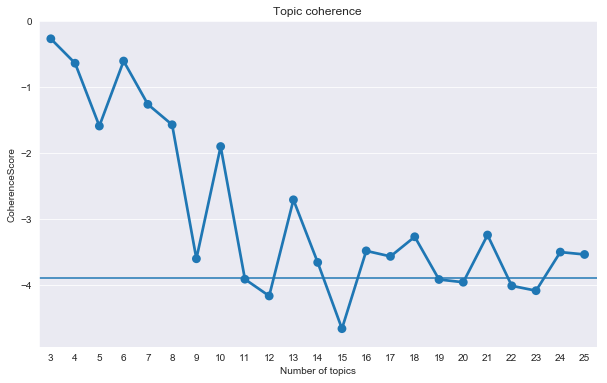

In [19]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig(dir_out+'Topic coherence plot.png')

In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.36218141943862

Coherence Score:  0.5870086835292812


## Dominant Topic in Document

In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            17.0              0.5159   
1            1            13.0              0.4776   
2            2             3.0              0.7082   
3            3             3.0              0.8432   
4            4            13.0              0.4776   
5            5            12.0              0.9933   
6            6            15.0              0.8604   
7            7             3.0              0.5071   
8            8            14.0              0.9928   
9            9            15.0              0.9545   

                                                                                              Keywords  \
0  company, systematically, sustainable, environmental, income, governance, social, medium, index, ...   
1                   china, share, mainland, investor, connect, list, restrict, foreign, chinese, stock   
2               objective, share, define, income, company, sell, buy, benchmark, constrain, prospectus   
3               objective, share, define, income, company, sell, buy, benchmark, constrain, prospectus   
4                   china, share, mainland, investor, connect, list, restrict, foreign, chinese, stock   
5                   objective, return, instrument, market, achieve, risk, hold, share, period, company   
6  environmental, distribute, dividend, sustainable, governance, company, social, basis, management...   
7               objective, share, define, income, company, sell, buy, benchmark, constrain, prospectus   
8                             eur, sub, money, market, ri, rate, financial, instrument, index, minimum   
9  environmental, distribute, dividend, sustainable, governance, company, social, basis, management...   

                                                                                                  Text  
0  [increase, value, medium, term, share, issue, indian, company, company, operate, country, active...  
1  [increase, value, medium, term, share, issue, company, conduct, business, water, relate, sector,...  
2  [objective, achieve, long, term, capital, growth, intend, primarily, share, company, consider, u...  
3  [objective, achieve, long, term, capital, growth, intend, primarily, share, company, asean, coun...  
4  [increase, value, medium, term, share, issue, company, conduct, business, food, supply_chain, ch...  
5  [objective, achieve, positive, total, return, market, condition, roll, year, period, target, gro...  
6  [increase, value, medium, term, share, issue, russian, company, company, operate, country, activ...  
7  [objective, achieve, long, term, capital, growth, intend, least, net, value, share, company, eur...  
8  [sub, money, market, define, money, market, regulation, achieve, performance, high, composite, i...  
9  [increase, value, medium, term, share, issue, indian, company, company, operate, country, active...

In [29]:
df_dominant_topic.to_excel(dir_out+"dominant_topic.xlsx")

In [5]:
kiid2topic = pd.read_excel("./outputs/lda/dominant_topic.xlsx")
kiid2topic.head()

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self,

Unnamed: 0  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0           0            0               9              0.9046   
1           1            1              19              0.9928   
2           2            2               2              0.8858   
3           3            3               2              0.9837   
4           4            4              19              0.9929   

                                            Keywords  \
0  company, medium, include, basis, index, bank, ...   
1  share, china, investor, environmental, sustain...   
2  share, objective, company, income, define, sel...   
3  share, objective, company, income, define, sel...   
4  share, china, investor, environmental, sustain...   

                                                Text  
0  ['increase', 'value', 'medium', 'term', 'share...  
1  ['increase', 'value', 'medium', 'term', 'share...  
2  ['objective', 'achieve', 'long', 'term', 'capi...  
3  ['objective', 'achieve', 'long', 'term', 'capi...  
4  ['increase', 'value', 'medium', 'term', 'share...

In [7]:
isin = kiid2table["share_class"]
kiid2topic = pd.concat([isin, kiid2topic], axis=1)

In [9]:
kiid2topic.to_excel(dir_out+"kiid2topic.xlsx")

### Representative Sentence

In [46]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.4709   
1        1.0              0.5137   
2        2.0              0.7945   
3        3.0              0.9723   
4        4.0              0.9667   
5        6.0              0.9915   
6        7.0              0.6025   
7        8.0              0.5563   
8       10.0              0.5200   
9       12.0              0.9935   

                                                                                   Keywords  \
0          convertible, bond, hedge, usd, class, return, eur, derivative, management, apply   
1                  base, value, approach, great, low, build, combine, eur, register, office   
2                    currency, hedge, bond, ri, exposure, risk, exchange, debt, eur, exceed   
3    objective, share, define, income, company, sell, buy, benchmark, constrain, prospectus   
4  instrument, debt, income, objective, generate, capital, gain, exposure, distress, market   
5                bond, market, class, debt, security, basis, policy, team, index, reference   
6    contingent, company, net, small, monthly, pay, include, europe, convertible, reinveste   
7     debt, real, estate, securitise, exposure, instrument, distress, gain, directly, grade   
8      reinveste, asia, stock, japan, quantitative, method, exclude, region, include, least   
9        objective, return, instrument, market, achieve, risk, hold, share, period, company   

                                                                                   Representative Text  
0  [increase, value, medium, term, convertible, bond, issue, company, world, exposure, class, fix, ...  
1  [increase, value, medium, term, share, issue, company, company, operate, usa, actively, manage, ...  
2  [increase, value, medium, term, high, yield, bond, debt, instrument, denominate, various, curren...  
3  [primary, objective, achieve, long, term, capital, growth, intend, primarily, share, company, ac...  
4  [objective, achieve, capital, growth, primarily, high, quality, short, term, debt, instrument, i...  
5  [increase, value, medium, term, target, volatility, basis, point, objective, achieve, diversify,...  
6  [objective, achieve, long, term, capital, growth, intend, primarily, share, small, company, euro...  
7  [objective, achieve, income, long, term, capital, growth, debt, instrument, financial, distress,...  
8  [objective, achieve, long, term, capital, growth, share, chinese, company, list, shanghai, shenz...  
9  [objective, achieve, positive, total, return, market, condition, roll, year, period, target, gro...

In [31]:
sent_topics_sorteddf_mallet.to_excel(dir_out+"sent_topics.xlsx")

## Document Word Counts

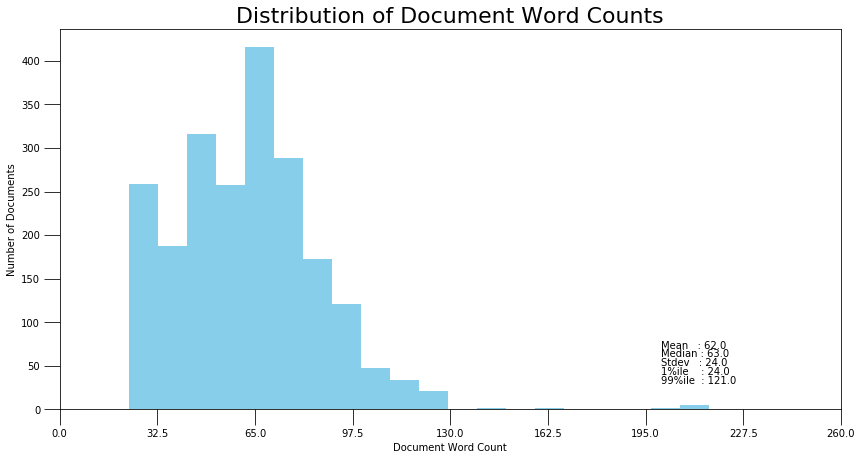

In [35]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(14,7)) 
           #dpi=160)
plt.hist(doc_lens, bins = 20, color='skyblue')
plt.text(200, 70, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(200,  60, "Median : " + str(round(np.median(doc_lens))))
plt.text(200,  50, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(200,  40, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(200,  30, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 260), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,260,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig(dir_out+'Documents words counts.png')
plt.show()

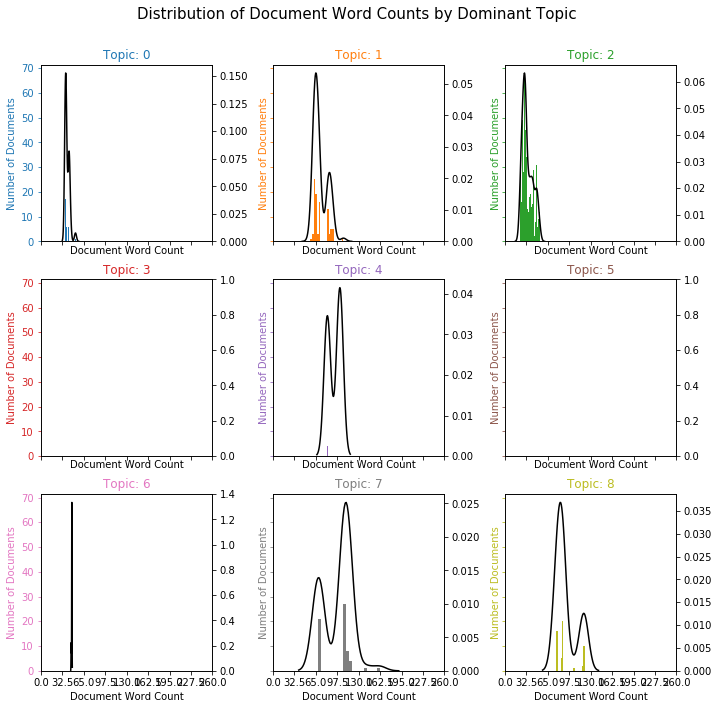

In [36]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 20, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 260), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,260,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=15)
plt.savefig(dir_out+'Words counts by topic.png')
plt.show()

## Wordclouds

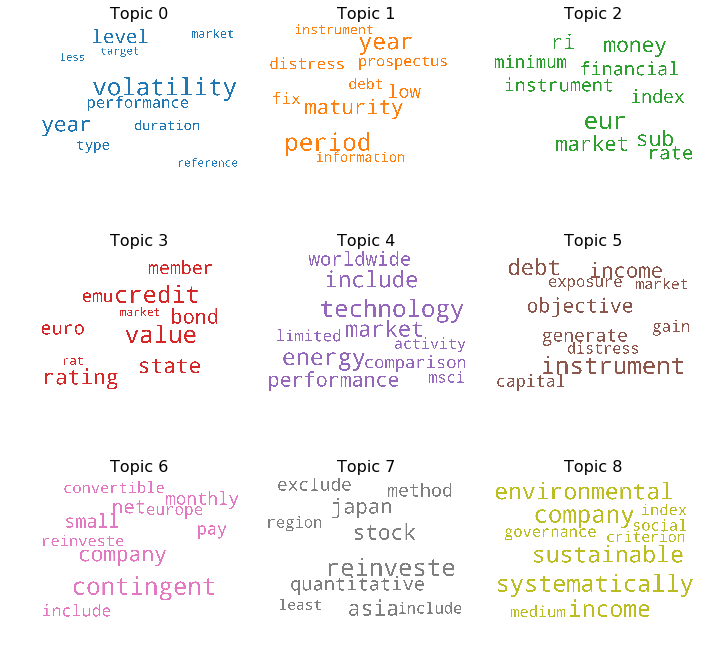

In [54]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(dir_out+'Wordclouds.png')
plt.show()

In [51]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.245806  0.163465       1        1  16.927151
17     0.297361  0.163255       2        1  16.899580
3     -0.215950  0.273563       3        1   9.562219
15     0.323461  0.130835       4        1   7.668234
18    -0.245820  0.147890       5        1   6.245987
6      0.187677  0.019959       6        1   6.003237
2      0.186680 -0.093849       7        1   5.632716
13     0.266517  0.146522       8        1   4.915100
12    -0.248067  0.106596       9        1   4.000216
1      0.061090 -0.022803      10        1   3.365696
14     0.105882 -0.079073      11        1   3.229485
10     0.024251  0.038743      12        1   2.816095
9     -0.043481 -0.272587      13        1   2.653093
7     -0.015292  0.092711      14        1   2.050907
0     -0.012458 -0.139429      15        1   1.960369
19    -0.108041 -0.126695      16        1   1.769031
8     -0.103038  0.002346      17        1   1.330188
11     0.010993 -0.036069      18        1   1.160907
20    -0.129999 -0.092951      19        1   0.852837
16    -0.010875 -0.249438      20        1   0.726842
5     -0.085084 -0.172991      21        1   0.230107, topic_info=           Term         Freq        Total Category  logprob  loglift
39        value  1803.000000  1803.000000  Default  30.0000  30.0000
53       growth  1259.000000  1259.000000  Default  29.0000  29.0000
102        debt  2125.000000  2125.000000  Default  28.0000  28.0000
77    objective  2607.000000  2607.000000  Default  27.0000  27.0000
76       market  2055.000000  2055.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
520        ucis     0.059618     1.154961  Topic21  -8.4866   3.1105
528    describe     0.059616     1.154943  Topic21  -8.4866   3.1105
529       equal     0.059616     1.154945  Topic21  -8.4866   3.1105
513  structured     0.059617     1.154954  Topic21  -8.4866   3.1105
76       market    12.799006  2055.691650  Topic21  -3.1174   0.9954

[913 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
284      20  0.718469    aaa
0         2  0.518140   able
0         4  0.233653   able
0         6  0.088289   able
0         7  0.047266   able
...     ...       ...    ...
152      21  0.162465   year
199       6  0.419713  yield
199       7  0.492707  yield
199      11  0.085159  yield
171      12  0.951477   zone

[1195 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 18, 4, 16, 19, 7, 3, 14, 13, 2, 15, 11, 10, 8, 1, 20, 9, 12, 21, 17, 6])

In [73]:
from collections import Counter
topics = lda_model.show_topics(num_topics=21, formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


21


word  topic_id  importance  word_count
0    convertible         0    0.084653         527
1           bond         0    0.084611        1163
2          hedge         0    0.077863         676
3            usd         0    0.063243         324
4          class         0    0.058947         395
..           ...       ...         ...         ...
205     distress        20    0.036060         692
206   prospectus        20    0.032287        1050
207         debt        20    0.031346        2129
208  information        20    0.026485          46
209   instrument        20    0.025100        2434

[210 rows x 4 columns]

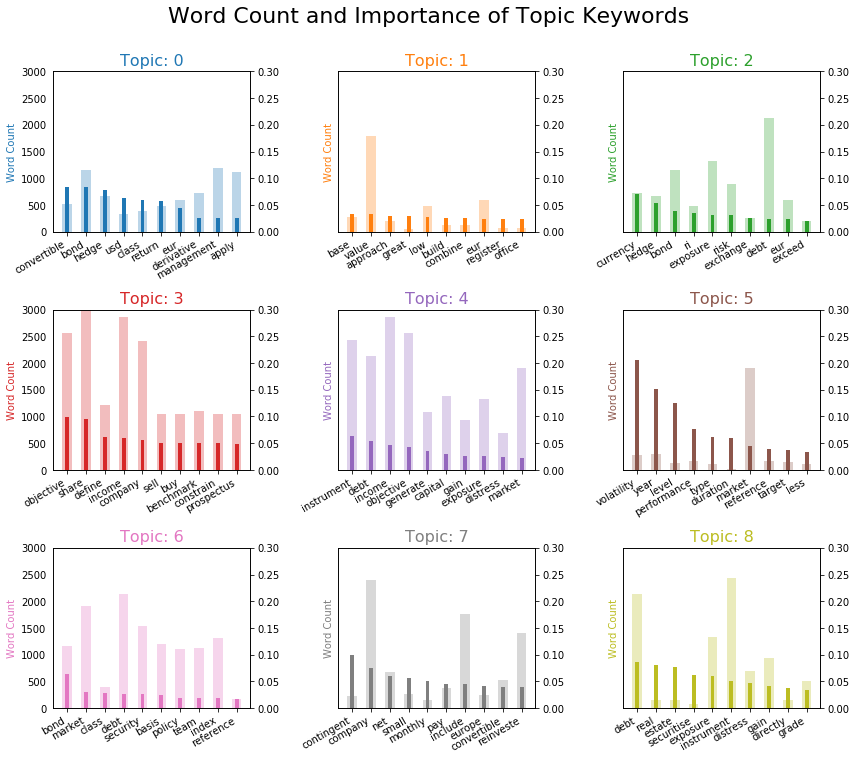

In [82]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(12,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.30); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    #ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.savefig(dir_out+'Words_weight.png')
plt.show()

## Concept Identification

In [32]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import itertools

In [5]:
kiid2keywords = pd.read_excel("./outputs/lda/kiid2topic.xlsx")
kiid2keywords

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/Users/airbooklea/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self,

Unnamed: 0   share_class  Document_No  Dominant_Topic  \
0              0  LU0823429740            0               9   
1              1  LU1664645287            1              19   
2              2  LU1981115113            2               2   
3              3  LU1934329050            3               2   
4              4  LU2066071577            4              19   
...          ...           ...          ...             ...   
2123        2123  LU1603801363         2123              17   
2124        2124  LU1701697515         2124               2   
2125        2125  LU1218206925         2125               0   
2126        2126  LU1775953497         2126               2   
2127        2127  LU1695654068         2127              19   

      Topic_Perc_Contrib                                           Keywords  \
0                 0.9046  company, medium, include, basis, index, bank, ...   
1                 0.9928  share, china, investor, environmental, sustain...   
2                 0.8858  share, objective, company, income, define, sel...   
3                 0.9837  share, objective, company, income, define, sel...   
4                 0.9929  share, china, investor, environmental, sustain...   
...                  ...                                                ...   
2123              0.8492  instrument, debt, objective, income, exposure,...   
2124              0.9807  share, objective, company, income, define, sel...   
2125              0.5405  quantitative, stock, method, define, objective...   
2126              0.6798  share, objective, company, income, define, sel...   
2127              0.4417  share, china, investor, environmental, sustain...   

                                                   Text  
0     ['increase', 'value', 'medium', 'term', 'share...  
1     ['increase', 'value', 'medium', 'term', 'share...  
2     ['objective', 'achieve', 'long', 'term', 'capi...  
3     ['objective', 'achieve', 'long', 'term', 'capi...  
4     ['increase', 'value', 'medium', 'term', 'share...  
...                                                 ...  
2123  ['objective', 'achieve', 'total', 'return', 'l...  
2124  ['objective', 'achieve', 'long', 'term', 'capi...  
2125  ['objective', 'achieve', 'long', 'term', 'capi...  
2126  ['objective', 'achieve', 'long', 'term', 'capi...  
2127  ['actively', 'manage', 'reference', 'index', '...  

[2128 rows x 7 columns]

In [129]:
#concept_list = []
lemma_list = []
for sample in kiid2keywords["Text"]:
    doc = nlp(sample)
    tokens = [tok for tok in doc]
    lemmas = []
    for tok in tokens:
        if tok.pos_ in ("NOUN", "ADJ"):
            lemmas.append(tok.lemma_.lower())
    #for lem in lemmas:
    #print(lemmas)
    lemma_list.append(lemmas)
#print(len(lemma_list))

potential_concept_list = []
for lemma in lemma_list:
    perm2 = list(itertools.permutations(lemmas, r=2))
    perm3 = list(itertools.permutations(lemmas, r=3))
    perm = perm2 + perm3
    potential_concepts =  [' '.join(tup for tup in elem)for elem in perm]
    potential_concept_list.append(potential_concepts)
potential_concept_list = set(potential_concept_list)
print(len(potential_concept_list))

KeyboardInterrupt: 

In [124]:
#term_list = ["Fund", "assets", "subfund"]
#txt_list = ["  The Fund seeks to increase the value of its assets over the medium term by investing in shares issued by Indian companies, or companies operating in this country. It is actively managed and as such may invest in securities that are not included in the index which is MSCI India USD NR. The investment team applies also BNP PARIBAS ASSET MANAGEMENT Sustainable Investment Policy, which takes into account Environmental, Social and Governance ESG criteria in the investments of the Fund. Income are systematically reinvested. Investors are able to redeem on a daily basis on Luxembourg bank business days . ",
            #"  The Fund seeks to increase the value of its assets over the medium term by investing in shares issued by Russian companies, or companies operating in this country. It is actively managed and as such may invest in securities that are not included in the index which is MSCI Russia 10 40 Hedged in ZAR NR. The investment team applies also BNP PARIBAS ASSET MANAGEMENT Sustainable Investment Policy, which takes into account Environmental, Social and Governance ESG criteria in the investments of the Fund. A dividend is distributed on a monthly basis. Investors are able to redeem on a daily basis on Luxembourg bank business days unless the London and or Moscow stock exchanges are closed. This share class aims at hedging the portfolio return from EUR to ZAR. "]
txt_list = [txt for txt in kiid2table["objectives"]]

list_count_concept = []
for potential_concept in potential_concept_list:
    for txt in txt_list:
        txt = txt.lower()
        list_count = []
        for term in potential_concepts:
            x = txt.find(term)
            if x != -1:
                dict_count = {term:x}
                list_count.append(dict_count)
    print(list_count)
    #list_count_concept.append(list_count)a
#print(len(list_count_concept))

[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'china share': 414}, {'management sustainable': 730}, {'foreign investor': 441}]
[{'c

KeyboardInterrupt: 

In [51]:
def is_proper_subset(set, superset):
     return all(x in superset for x in set) and len(set)<len(superset)

In [53]:
a = ['debt instrument', 'market instrument', 'market exposure', 'gain exposure', 'income instrument', 'market capital', 'capital gain', 'market debt']
b = ['debt instrument', 'market instrument']
is_proper_subset(b, a)

True

In [ ]:
# subsumption relation if documents where c1 occurs > documents where c2 occurs

[{'Fund': 6}, {'assets': 46}]
[{'Fund': 6}, {'assets': 46}]


In [ ]:
# use all keywords of a topic
# identify POS: N, J
#form combinations: Noun + Noun, adj + Noun, ...
# calculate term count with original corpus (term is in objectives?)
# if term count = 0, not a concept

## Sentence Colored

ValueError: too many values to unpack (expected 2)

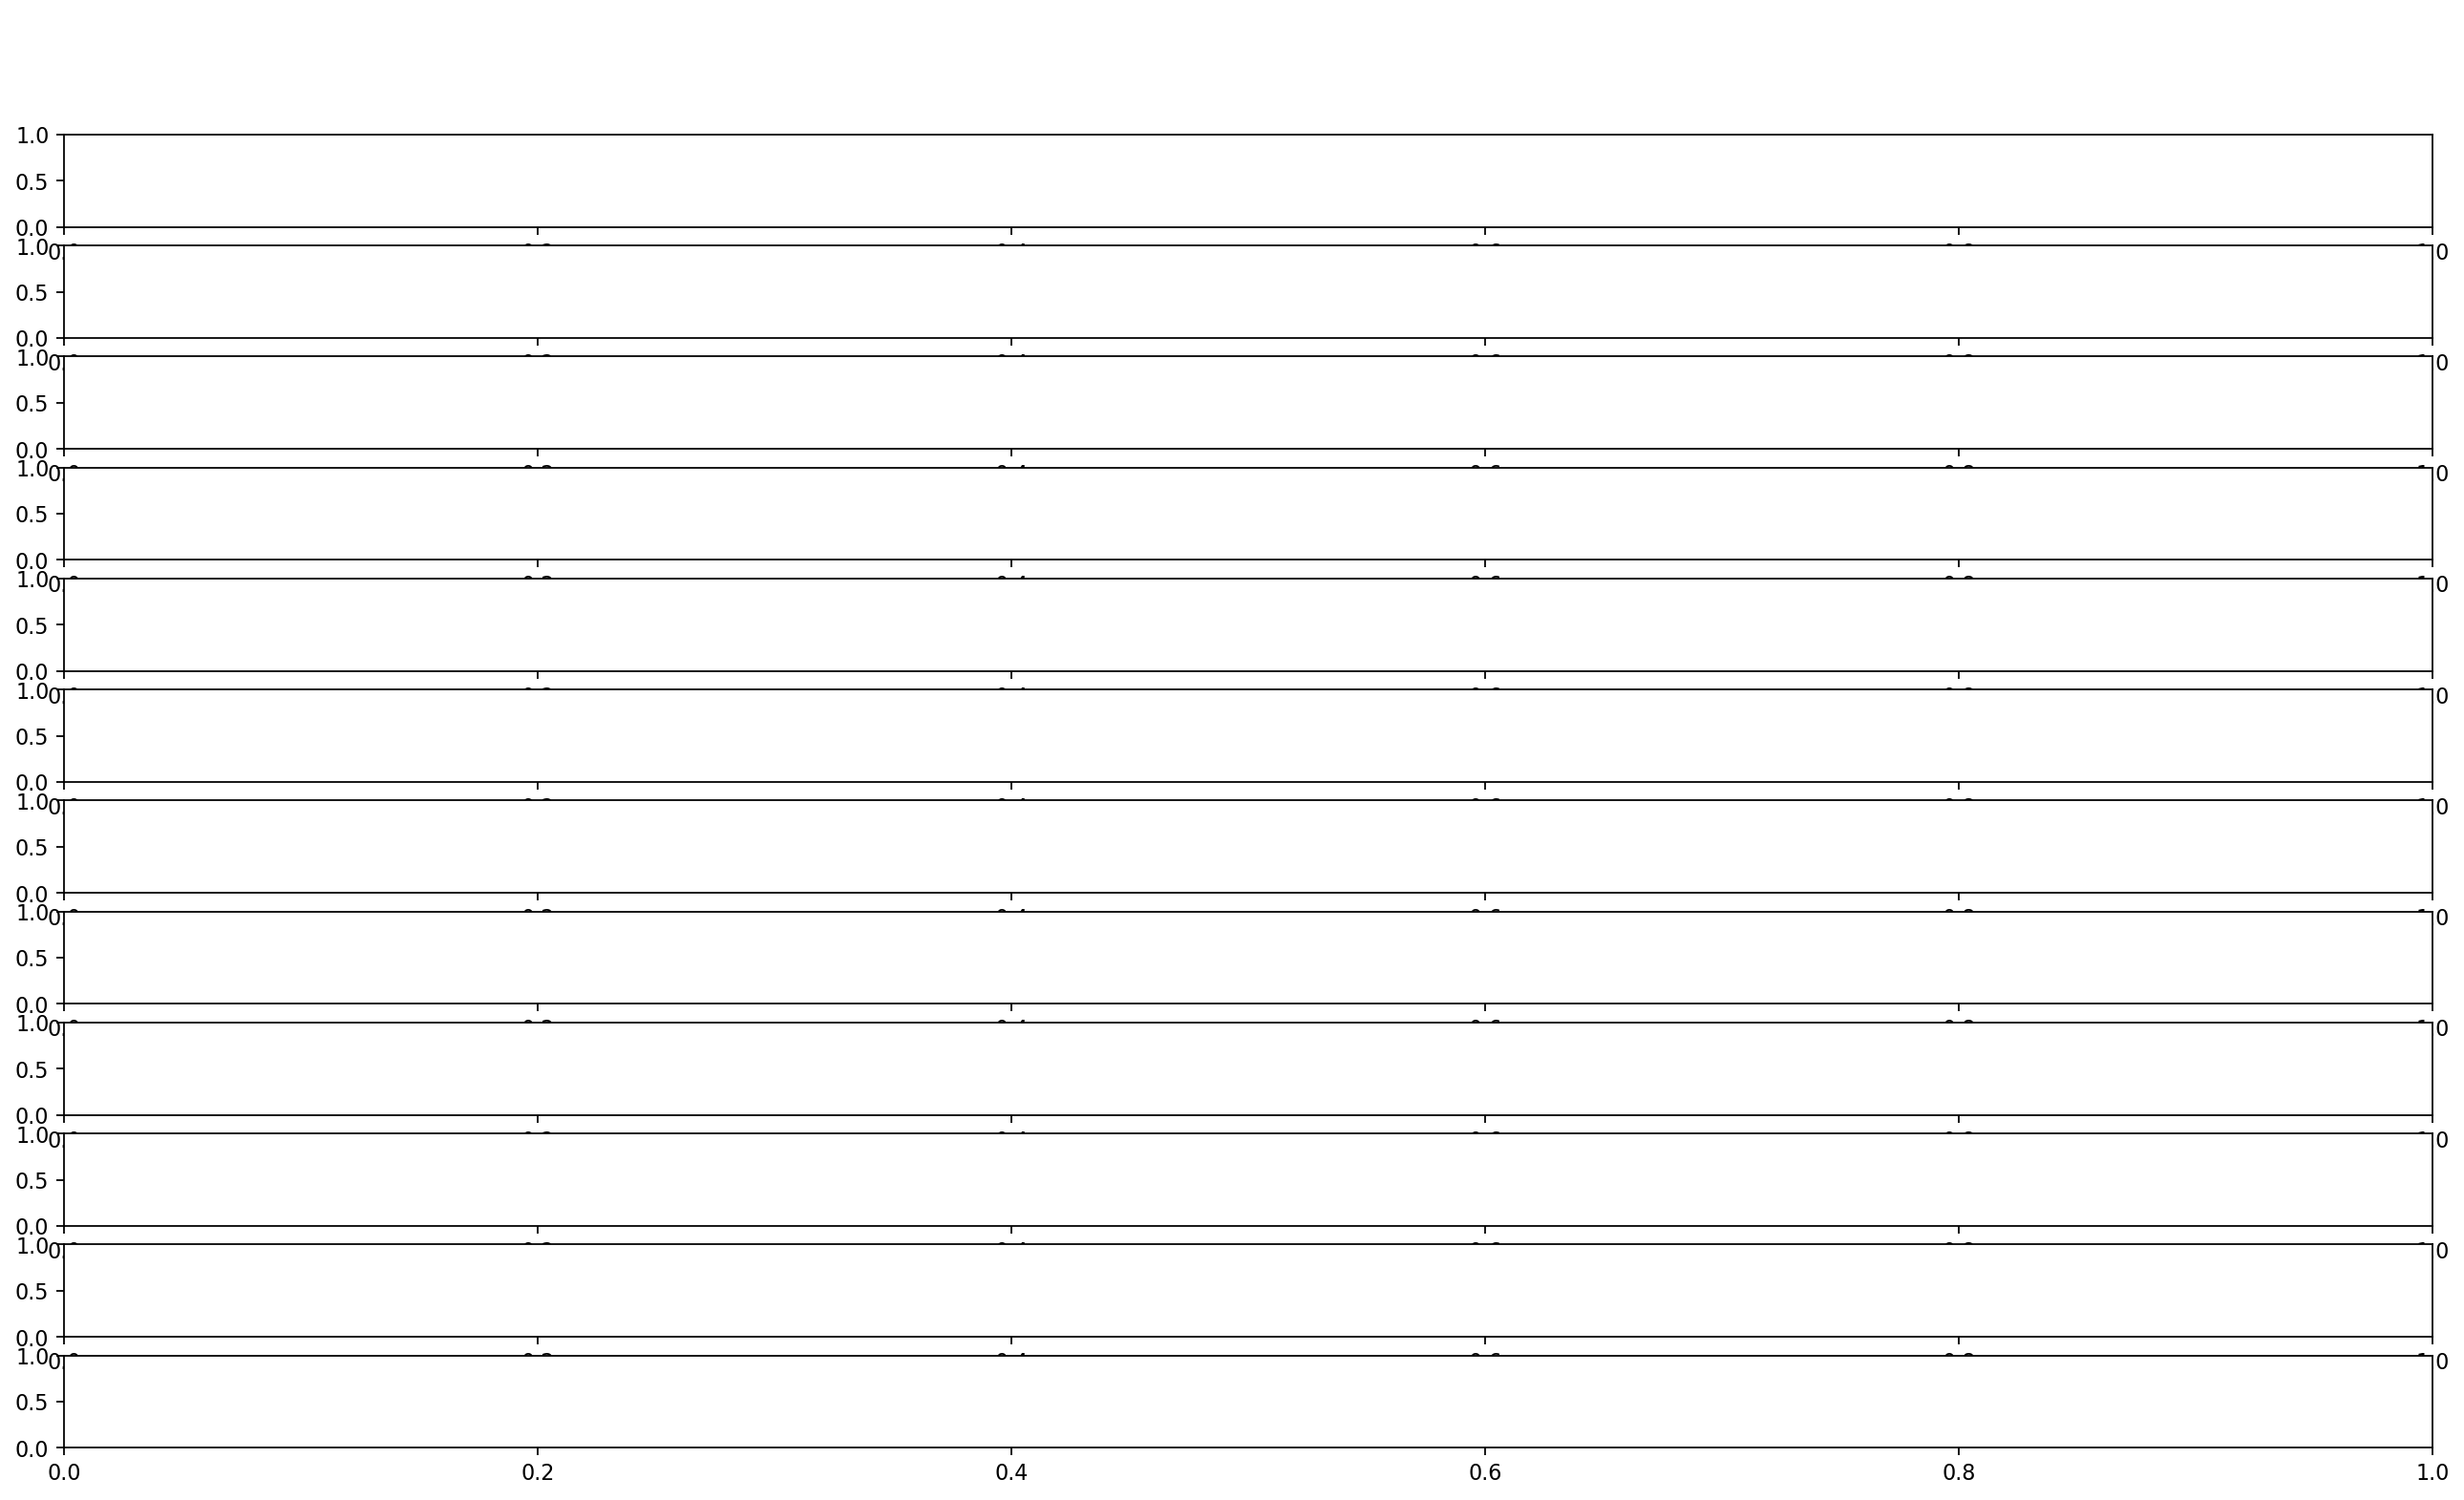

In [83]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            #topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            wordid_topics = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectangle
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [136]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

ValueError: not enough values to unpack (expected 3, got 2)

NameError: name 'df_dominant_topic_in_each_doc' is not defined

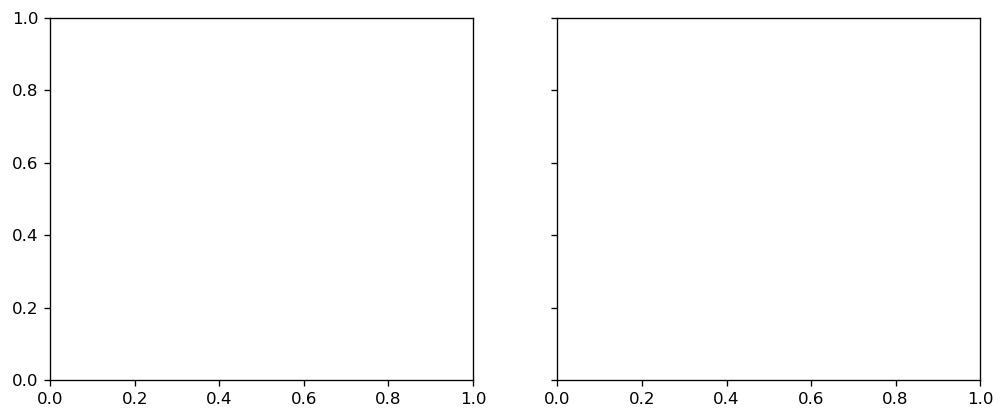

In [137]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [89]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 21
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2084 samples in 0.002s...
[t-SNE] Computed neighbors for 2084 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2084
[t-SNE] Computed conditional probabilities for sample 2000 / 2084
[t-SNE] Computed conditional probabilities for sample 2084 / 2084
[t-SNE] Mean sigma: 0.002019
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.671124
[t-SNE] KL divergence after 1000 iterations: 0.216201


Loading BokehJS ...

In [ ]:
################

In [154]:
dir_out = "./data/output/prosp_obj"
file_list = [f for f in os.listdir(dir_out)]
doc_lda_list = []
for f in file_list:
    with open(os.path.join(dir_out, f)) as data:
        document = data.read()
        doc_bow = id2word.doc2bow(document.split())
        doc_lda = lda_model[doc_bow]
        doc_lda_list.append(doc_lda)

In [155]:
doc_lda_list[10]

[(15, 0.99214864)]